# Modelling with Meridian

This notebook uses the `google-meridian` package to run Bayesian MMM models. For more information on meridian, you can access the docs [here](https://developers.google.com/meridian/notebook/meridian-getting-started).

In [1]:
# meridian funcitons
from meridian.data.data_frame_input_data_builder import DataFrameInputDataBuilder
from meridian.model.model import Meridian
from meridian.analysis import optimizer
from meridian.analysis import summarizer
from meridian.analysis import visualizer
from meridian.model import model
from meridian.model import prior_distribution as pdist, spec as specmod

# data manipulation/viz
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [15, 7]

# other
import warnings
warnings.filterwarnings('ignore')

## Importing Data
The `formatted_data.csv` contains all the media variables, and the control variables (e.g. price, economy, events).

In [2]:
# Load your data
df = pd.read_csv("./data/formatted_data_simple.csv")
df["date"] = pd.to_datetime(df["date"],format = "%d/%m/%Y")
kpi_name = "sales"

In [3]:
df.head()

,date,sales,economy,seasonality,price,event_dummy_1,event_dummy_2,tv_spend,radio_spend,display_spend,vod_spend,non_brand_ppc_spend,brand_ppc_spend
0,2022-01-01,1086940.448,0.000000,1.230577,0.5,0,0,0,10000,33709.58447,0.0,14475.353890,15626.77642
1,2022-01-08,1271357.442,0.019591,1.284311,0.5,0,0,0,20000,14353.01829,0.0,8717.000849,22158.60099
2,2022-01-15,1313040.475,0.039020,1.323333,0.5,0,0,0,10000,23631.28411,0.0,10655.462790,41861.81096
3,2022-01-22,1330751.387,0.058285,1.347910,0.5,0,0,0,50000,26328.62605,0.0,23887.840440,25628.34534
4,2022-01-29,1432413.111,0.077385,1.359223,0.5,0,0,0,20000,24042.68323,0.0,13256.402670,19663.92647


## Model Specification
The control and media variable names are stored in the `control_cols` and `media_cols` lists, respectively.

In [4]:
# control columns lists:
all_cols = df.columns.tolist()

media_cols = [
 'tv_spend',
 'radio_spend',
 'display_spend',
 'vod_spend',
 'non_brand_ppc_spend',
 'brand_ppc_spend']

exclude = set(media_cols + ["date", kpi_name])
control_cols = [c for c in all_cols if c not in exclude]

In [5]:
all_cols

['date',
 'sales',
 'economy',
 'seasonality',
 'price',
 'event_dummy_1',
 'event_dummy_2',
 'tv_spend',
 'radio_spend',
 'display_spend',
 'vod_spend',
 'non_brand_ppc_spend',
 'brand_ppc_spend']

In [6]:
# using meridian's DataFrameInputDataBuilder to define the model specification:

builder = DataFrameInputDataBuilder(kpi_type="revenue") \
    .with_kpi(df, kpi_col=kpi_name, time_col="date") \
    .with_media(
        df,
        media_cols=media_cols,
        media_spend_cols=media_cols,        # same as media_cols if already in spend units
        media_channels=media_cols,          # channel labels (can be same as col names)
        time_col="date"
    )\
    .with_non_media_treatments(
        df, 
        non_media_treatment_cols=control_cols, 
        time_col="date"
    )

input_data = builder.build()
model_spec = specmod.ModelSpec(
    knots=1,   # single coefficient over time -> constant baseline
)


## Running the Model
Setting parameters for the bayesian regression like `n_chains`. These parameters allow for a relatively quick model run, but you'll want to increase the values below when running these models in production. 

In [7]:
%%time
mmm = Meridian(input_data=input_data)
mmm.sample_prior(500)
mmm.sample_posterior(
    n_chains=2, n_adapt=2000, n_burnin=500, n_keep=1000, seed=0
)

CPU times: total: 2min 22s
Wall time: 2min 26s


## Charts

Visualising R-hats, model fit, decompositions, and ROIs.

In [8]:
model_diagnostics = visualizer.ModelDiagnostics(mmm)
model_diagnostics.plot_rhat_boxplot()

alt.LayerChart(...)

In [9]:
model_fit = visualizer.ModelFit(mmm)
model_fit.plot_model_fit()

alt.LayerChart(...)

In [10]:
media_summary = visualizer.MediaSummary(mmm)
media_summary.plot_channel_contribution_area_chart()

alt.Chart(...)

In [11]:
media_summary.plot_spend_vs_contribution()

alt.FacetChart(...)

In [12]:
contrib = media_summary.contribution_metrics(
    include_non_paid=True,
    aggregate_times=False
)
contrib.head()

,time,channel,incremental_outcome,pct_of_contribution
0,2022-01-01,baseline,610211.687500,0.502353
163,2022-01-01,seasonality,395077.218750,0.325246
160,2022-01-01,non_brand_ppc_spend,91086.382812,0.074986
158,2022-01-01,display_spend,82665.445312,0.068054
161,2022-01-01,brand_ppc_spend,20889.255859,0.017197


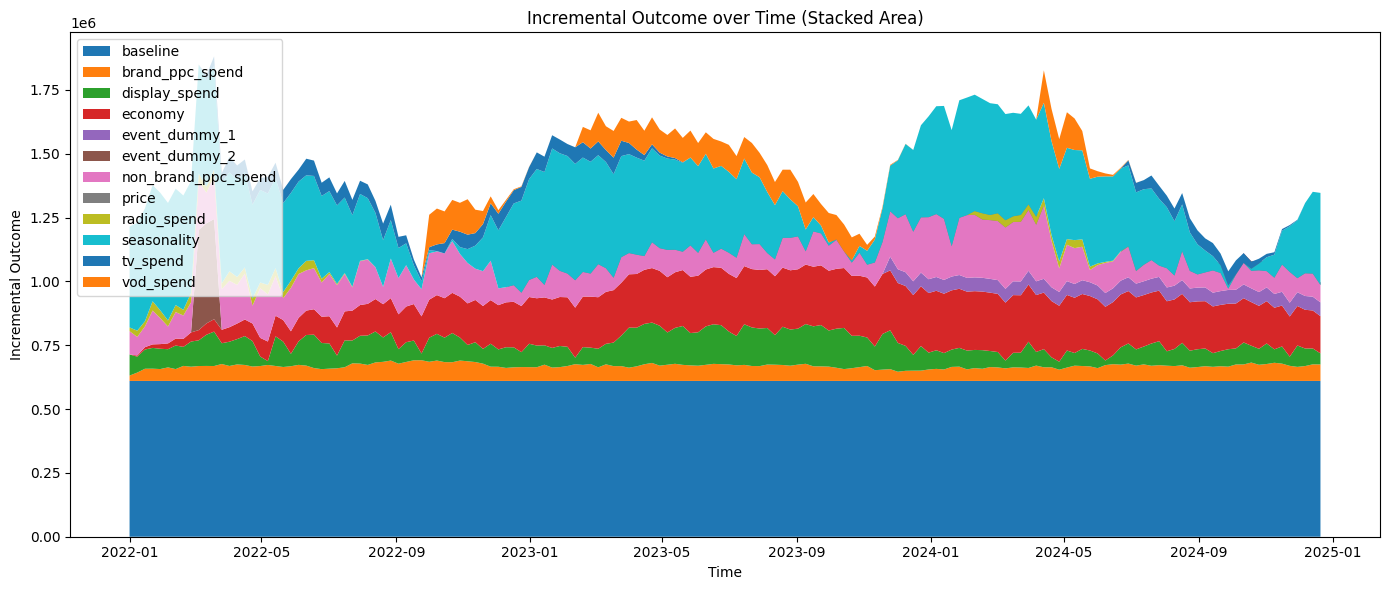

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ensure time is datetime
contrib["time"] = pd.to_datetime(contrib["time"])

# pivot to wide format for stacking
area_df = contrib.pivot_table(
    index="time",
    columns="channel",
    values="incremental_outcome",
    aggfunc="sum"        # if multiple rows per time/channel
).fillna(0)

# sort by time
area_df = area_df.sort_index()

# plot
plt.figure(figsize=(14, 6))
plt.stackplot(
    area_df.index,
    area_df.T,          # values as separate arrays
    labels=area_df.columns
)

plt.title("Incremental Outcome over Time (Stacked Area)")
plt.xlabel("Time")
plt.ylabel("Incremental Outcome")
plt.legend(loc="upper left")
plt.tight_layout()
plt.show()


## Optimisation
Using the model to generate an optimised the media mix

In [46]:
%%time
budget_optimizer = optimizer.BudgetOptimizer(mmm)
optimization_results = budget_optimizer.optimize()
optimization_results.plot_response_curves()

CPU times: total: 1min 30s
Wall time: 1min 29s


alt.FacetChart(...)

In [86]:
### interpolate curves

In [87]:
def weekly_spend_response_curve(
    mmm,
    channel: str,
    spend_min: int = 0,
    spend_max: int = 100_000,
    spend_step: int = 1_000,
):
    """
    Returns a dataframe mapping WEEKLY spend -> WEEKLY incremental revenue
    using Meridian's response_curves (interpolated).

    Output columns:
      spend, revenue
    """
    from meridian.analysis import analyzer as analyzer_lib

    an = analyzer_lib.Analyzer(mmm)
    rc = an.response_curves(spend_multipliers=np.linspace(0, 4, 21))

    # select channel
    rc_ch = rc.sel(channel=channel)

    # cumulative spend + cumulative incremental outcome
    spend_total = rc_ch["spend"].values
    revenue_total = rc_ch["incremental_outcome"].sel(metric="mean").values

    # convert cumulative -> weekly
    n_weeks = len(mmm.input_data.time)
    spend_weekly = spend_total / n_weeks
    revenue_weekly = revenue_total / n_weeks

    # ensure monotonic ordering
    order = np.argsort(spend_weekly)
    spend_weekly = spend_weekly[order]
    revenue_weekly = revenue_weekly[order]

    # target weekly spend grid
    target_spend = np.arange(spend_min, spend_max + spend_step, spend_step)

    # interpolate (clip outside range)
    revenue_interp = np.interp(
        target_spend,
        spend_weekly,
        revenue_weekly,
        left=0.0,
        right=revenue_weekly[-1],
    )

    return pd.DataFrame({
        "spend": target_spend.astype(float),
        "revenue": revenue_interp.astype(float),
    })


    spend       revenue
0     0.0      0.000000
1  1000.0   6969.763096
2  2000.0  13939.526192
3  3000.0  20909.289288
4  4000.0  27879.052385


<Axes: xlabel='spend', ylabel='revenue'>

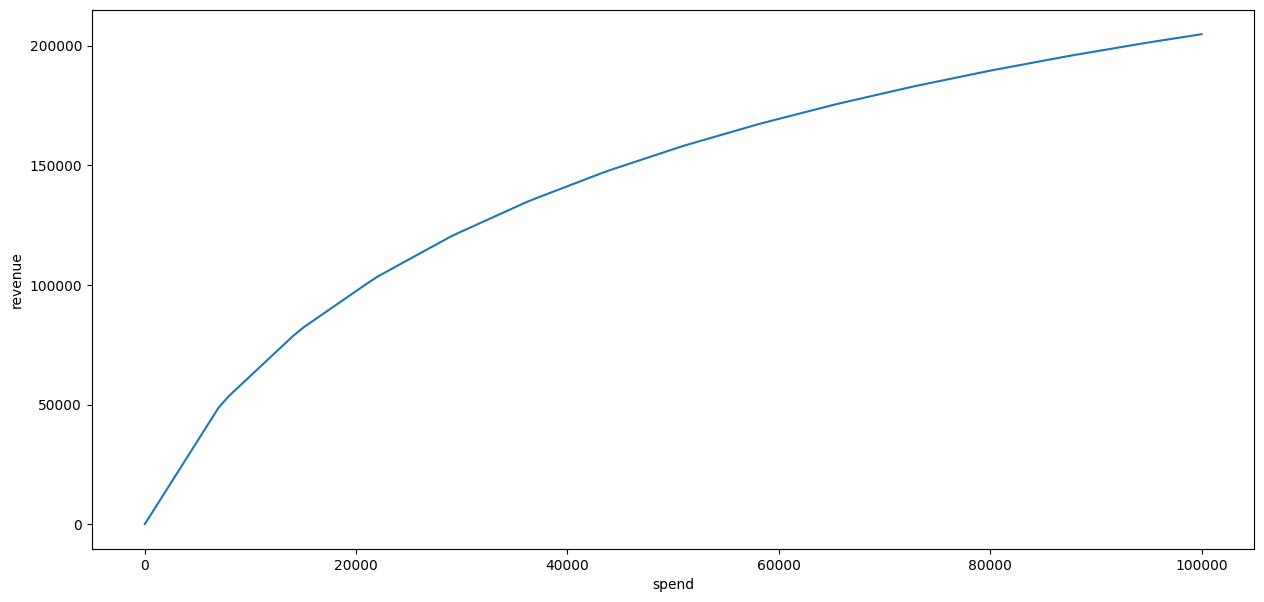

In [88]:
curve_df = weekly_spend_response_curve(
    mmm=mmm,
    channel="non_brand_ppc_spend",
    spend_max=100_000,
)

print(curve_df.head())

sns.lineplot(data = curve_df,x = "spend", y = "revenue")


In [89]:
### Verify Interpolation

In [90]:
def plot_weekly_interp_vs_meridian(
    mmm,
    channel: str,
    df_weekly,  # output of weekly_spend_response_curve()
):
    from meridian.analysis import analyzer as analyzer_lib

    # -----------------------------
    # Meridian response curves
    # -----------------------------
    an = analyzer_lib.Analyzer(mmm)
    rc = an.response_curves(spend_multipliers=np.linspace(0, 4, 21))
    rc_ch = rc.sel(channel=channel)

    spend_total = rc_ch["spend"].values
    revenue_total = rc_ch["incremental_outcome"].sel(metric="mean").values

    n_weeks = len(mmm.input_data.time)
    spend_weekly = spend_total / n_weeks
    revenue_weekly = revenue_total / n_weeks

    # sort
    order = np.argsort(spend_weekly)
    spend_weekly = spend_weekly[order]
    revenue_weekly = revenue_weekly[order]

    # -----------------------------
    # Plot
    # -----------------------------
    plt.figure(figsize=(8, 5))

    plt.plot(
        df_weekly["spend"],
        df_weekly["revenue"],
        label="Interpolated weekly curve",
        linewidth=2,
    )

    plt.plot(
        spend_weekly,
        revenue_weekly,
        label="Meridian response_curves (weekly)",
        linewidth=2,
    )

    plt.xlabel("Weekly spend")
    plt.ylabel("Weekly incremental revenue")
    plt.title(channel)
    plt.legend()
    plt.grid(True)

    plt.show()


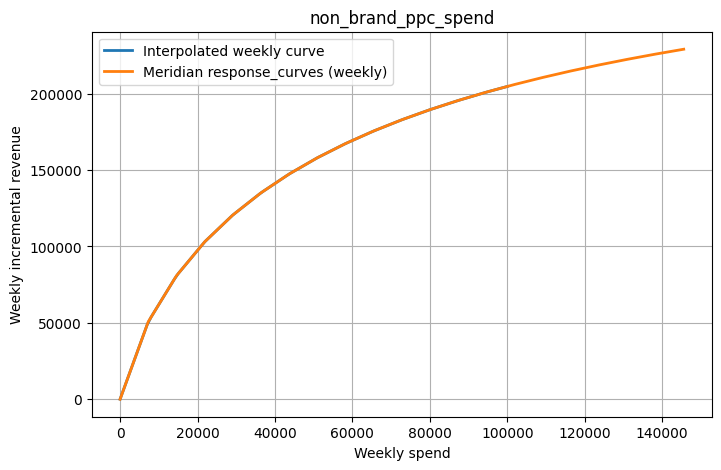

In [91]:
plot_weekly_interp_vs_meridian(
    mmm=mmm,
    channel="non_brand_ppc_spend",
    df_weekly=curve_df,
)